<font size=6>Downloading required libraries</font>

In [766]:
!pip3 install -q numpy
!pip3 install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu128
!pip3 install torch torchinfo
!pip3 install torch tensorboard
!pip3 install -q pretty_midi
!pip3 install -q gensim
!pip3 install -q nltk

Looking in indexes: https://download.pytorch.org/whl/cu128


<font size=6>Imports</font>

In [767]:
import torch
import os
import torch.nn as nn
import torch.utils.data as data
import time
import torch.nn.functional as F
import random
import copy
import numpy as np
import math
import matplotlib.pyplot as plt
from collections import defaultdict
from torchinfo import summary
from typing import Optional
import csv
import string
from pretty_midi import PrettyMIDI, Note
from sklearn.model_selection import train_test_split
import re
import gensim.downloader
import nltk
from nltk.corpus import stopwords
from collections import Counter
nltk.download('stopwords')
import pickle
from torch.utils.tensorboard import SummaryWriter
from collections import deque

os.environ['KMP_DUPLICATE_LIB_OK'] = 'True'

print("Using torch", torch.__version__)
device = 'cuda' if torch.cuda.is_available() else 'cpu'

Using torch 2.8.0+cu128


[nltk_data] Downloading package stopwords to C:\Users\Aviv
[nltk_data]     Metz\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


<font size=6>Constants</font>

In [768]:
LYRIC_TRAIN_SET_CSV_PATH: str = os.path.join(os.getcwd(), 'data', 'lyrics_train_set.csv')
LYRIC_TEST_SET_CSV_PATH: str = os.path.join(os.getcwd(), 'data', 'lyrics_test_set.csv')
MIDI_FILE_PATH: str = os.path.join(os.getcwd(), 'data', 'midi_files')
PICKLING_PATH: str = os.path.join(os.getcwd(), 'loaded_midi_files.pkl') # Path to save/load pickled MIDI files, for faster loading.
EPSILON: float = 1e-9
SEQUENCE_LENGTH: int = 10  # Number of words in the input sequence
BATCH_SIZE: int = 128
LSTM_LAYERS: int = 2
ATTENTION_LAYERS: int = 2
DROPOUT: float = 0.3
ATTENTION_DROPOUT: float = 0.2
RANDOM_LOADER_SEED: int = 42
VALIDATION_SPLIT: float = 0.1
LEARNING_RATE: float = 0.001
MAX_EPOCHS: int = 100
NUMBER_OF_EXTRACT_MIDI_FEATURES: int = 25
WORD_EMBEDDING_SIZE: int = 300
SIZE_OF_ARTIST_INDEX: int = 1
PATIENCE_FACTOR: float = 0.001
PATIENCE_EPOCHS: int = 10
UNK_ID: int = 0
MIN_LINE_LENGTH: int = 5
MAX_LINE_LENGTH: int = SEQUENCE_LENGTH
EOL_STRING: str = '<eol>'
UNK_STRING: str = '<unk>'
EOS_STRING: str = '<eos>'
TOP_K_WORDS_TO_PREDICT: int = 20
MAX_SONG_LENGTH_WORDS: int = 80
HIDDEN_LAYER_DIM: int = 256
HIDDEN_LAYER_DIM_ATTENTION: int = 256
SEED = 42
VERBOSE: str = True
NOTE_SAMPLING_INTERVAL_SHORT: float = 0.10
NOTE_SAMPLING_INTERVAL_LONG: float = 0.50
RHYTHM_FEATURES: str = 'RHYTHM_FEATURES'
HARMONY_FEATURES: str = 'HARMONY_FEATURES'
torch.manual_seed(SEED)
np.random.seed(SEED)
random.seed(SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(SEED)

<font size=6>Midi Feature extraction</font>

Auxlliary functions

In [769]:
def most_common_time_signature(changes: tuple[int, int]) -> tuple[int, int]:
    if not changes: return (4, 4)
    pairs: list[tuple[int, int]] = [(ts.numerator, ts.denominator) for ts in changes]
    return Counter(pairs).most_common(1)[0][0]

In [770]:
def get_duration_weighted_pitch_stats(notes: list[Note]) -> dict[str, float]:
    """
    Compute pitch statistics weighted by each note's duration.
    Returns a dict with:
      mean (duration-weighted),
      std  (duration-weighted),
      p10 / p50 / p90 (duration-weighted percentiles),
      ambitus = p90 - p10 (robust range).
    If `notes` is empty, returns safe defaults.
    """
    # Empty guard: nothing to measure → return neutral stats.
    if not notes:
        return dict(mean=0.0, std=0.0, p10=-1, p50=-1, p90=-1, ambitus=0.0)

    # Vectorize pitches as float for math (MIDI 0..127, but floats simplify ops).
    pitches: np.ndarray[np.float32] = np.fromiter((n.pitch for n in notes), dtype=np.float32)

    # Each note's weight = its duration in seconds; clamp tiny/negative to epsilon.
    weights: np.ndarray[np.float32] = np.fromiter((max(EPSILON, n.end - n.start) for n in notes), dtype=np.float32)
    total_weights: float = weights.sum()
    duration_weight_mean: float = float((weights * pitches).sum() / total_weights)
    duration_weighted_variance: float = float((weights * (pitches - duration_weight_mean) ** 2).sum() / total_weights)
    weighted_std: float = duration_weighted_variance ** 0.5

    # ---------- Duration-weighted percentiles ----------
    order: np.ndarray[np.int32] = np.argsort(pitches)
    ordered_pitches, ordered_weights = pitches[order], weights[order]
    cumulative_weight_sum: np.ndarray[np.float32] = np.cumsum(ordered_weights)

    # Weighted quantile: find the first index where cumulative weight crosses q%.
    def weighted_quantile(quantile: float) -> float:
        # Target cumulative weight at quantile q (0..100).
        target: float = (quantile / 100.0) * cumulative_weight_sum[-1]
        # Index where cumulative_weight_sum >= target; take leftmost to be consistent.
        idx: int = np.searchsorted(cumulative_weight_sum, target, side="left")
        return float(ordered_pitches[min(idx, len(ordered_pitches) - 1)])

    # 10th / 50th (median) / 90th percentiles, duration-weighted.
    percentile_10, percentile_50, percentile_90 = weighted_quantile(10), weighted_quantile(50), weighted_quantile(90)

    # Ambitus = robust spread (p90 - p10), less sensitive than raw max - min.
    return dict(mean=duration_weight_mean, 
                std=weighted_std,
                p10=percentile_10, 
                p50=percentile_50, 
                p90=percentile_90)


In [771]:
def tempo_stats(midi: PrettyMIDI) -> tuple[float, float, int]:
    tempo_times, tempo_bpms = midi.get_tempo_changes()
    if len(tempo_bpms) == 0:
        tempo_times = np.array([0.0], dtype=np.float32)
        tempo_bpms  = np.array([midi.estimate_tempo()], dtype=np.float32)

    # duration-weighted mean tempo + dispersion proxy
    duration_sec = midi.get_end_time()
    segment_ends: np.ndarray[np.float32] = np.r_[tempo_times[1:], duration_sec]
    segment_durs: np.ndarray[np.float32] = np.maximum(EPSILON, segment_ends - tempo_times[:len(segment_ends)])
    tempo_mean: float = float(np.dot(tempo_bpms[:len(segment_durs)], segment_durs) / np.sum(segment_durs))
    tempo_std: float = float(np.std(np.repeat(
        tempo_bpms[:len(segment_durs)],
        np.maximum(1, (segment_durs/np.sum(segment_durs)*1000).astype(int))
    )))
    tempo_change_count: int = int(len(tempo_bpms))
    return tempo_mean, tempo_std, tempo_change_count

In [772]:
def collect_melodic_material(midi: PrettyMIDI) -> tuple[list[Note], list[int]]:
    notes: list[Note] = []
    velocities: list[int] = []
    for inst in midi.instruments:
        if inst.is_drum or not inst.notes:
            continue
        notes.extend(inst.notes)
        velocities.extend([n.velocity for n in inst.notes])
    return notes, velocities

In [773]:

def instrument_count_non_drum_with_notes(midi: PrettyMIDI) -> int:
    return sum(1 for inst in midi.instruments if not inst.is_drum and inst.notes)

In [774]:
def note_duration_stats(notes: list[Note]) -> tuple[float, float, float, float, float, float]:
    if not notes:
        return 0.0, 0.0, 0.0, 0.0, 0.0, 0.0
    durs = np.array([max(EPSILON, n.end - n.start) for n in notes], dtype=np.float32)
    mean = float(durs.mean())
    std  = float(durs.std())
    rng  = float(durs.max() - durs.min())
    cv   = float(std / max(EPSILON, mean))
    p10  = float(np.percentile(durs, 10))
    p90  = float(np.percentile(durs, 90))
    return mean, std, rng, cv, p10, p90

In [775]:
def ioi_stats(notes: list[Note]) -> tuple[float, float, float, float, float]:
    if not notes:
        return 0.0, 0.0, 0.0, 0.0, 0.0
    starts = np.array(sorted(n.start for n in notes), dtype=np.float32)
    if len(starts) < 2:
        return 0.0, 0.0, 0.0, 0.0, 0.0
    iois = np.diff(starts)
    iois = np.clip(iois, EPSILON, None)
    mean = float(iois.mean())
    std  = float(iois.std())
    cv   = float(std / max(EPSILON, mean))
    short_ratio = float((iois <= NOTE_SAMPLING_INTERVAL_SHORT).mean())
    long_ratio  = float((iois >= NOTE_SAMPLING_INTERVAL_LONG).mean())
    return mean, std, cv, short_ratio, long_ratio

In [776]:
def rest_ratio_extraction(notes: list[Note], duration_sec: float) -> float:
    if not notes or duration_sec <= 0:
        return 0.0
    notes_sorted = sorted(notes, key=lambda n: n.start)
    gaps = []
    for a, b in zip(notes_sorted[:-1], notes_sorted[1:]):
        gap = max(0.0, b.start - a.end)
        if gap > 0:
            gaps.append(gap)
    return float(sum(gaps) / max(EPSILON, duration_sec))

In [777]:
def velocity_stats(velocities: list[int]) -> tuple[float, float, float, float]:
    if not velocities:
        return 0.0, 0.0, 0.0, 0.0
    arr = np.array(velocities, dtype=np.float32)
    vmin, vmax = float(arr.min()), float(arr.max())
    vmean, vstd = float(arr.mean()), float(arr.std())
    vcv = float(vstd / max(EPSILON, vmean))
    return vmin, vmax, vmean, vstd if vmean == 0 else vcv  # keep both std and cv separately elsewhere if needed

In [778]:
def velocity_min_max_mean_std_cv(velocities: list[int]) -> tuple[float, float, float, float, float]:
    if not velocities:
        return 0.0, 0.0, 0.0, 0.0, 0.0
    arr = np.array(velocities, dtype=np.float32)
    vmin = float(arr.min())
    vmax = float(arr.max())
    vmean = float(arr.mean())
    vstd  = float(arr.std())
    vcv   = float(vstd / max(EPSILON, vmean))
    return vmin, vmax, vmean, vstd, vcv

In [779]:
def interval_stats(notes: list[Note]) -> tuple[float, float, float]:
    if not notes:
        return 0.0, 0.0, 0.0
    ns = sorted(notes, key=lambda n: n.start)
    if len(ns) < 2:
        return 0.0, 0.0, 0.0
    pitches = np.array([n.pitch for n in ns], dtype=np.float32)
    steps = np.diff(pitches)
    abs_steps = np.abs(steps)
    if abs_steps.size == 0:
        return 0.0, 0.0, 0.0
    avg_abs = float(abs_steps.mean())
    small_step_ratio = float((abs_steps <= 2).mean())
    large_leap_ratio = float((abs_steps >= 7).mean())
    return avg_abs, small_step_ratio, large_leap_ratio

In [780]:
def pitch_time_slope(notes: list[Note]) -> float:
    if not notes:
        return 0.0
    ns = sorted(notes, key=lambda n: n.start)
    if len(ns) < 2:
        return 0.0
    t = np.array([n.start for n in ns], dtype=np.float32)
    p = np.array([n.pitch for n in ns], dtype=np.float32)
    t = (t - t.mean()) / (t.std() + EPSILON)
    p = (p - p.mean()) / (p.std() + EPSILON)
    return float(np.clip(np.corrcoef(t, p)[0,1], -1.0, 1.0))

In [781]:
def distinct_pitch_and_repetition(notes: list[Note]) -> tuple[float, float]:
    if not notes:
        return 0.0, 0.0
    pitches = [n.pitch for n in notes]
    total = len(pitches)
    distinct_ratio = float(len(set(pitches)) / max(1, total))
    # repetition as mode frequency / total
    values, counts = np.unique(pitches, return_counts=True)
    repetition_ratio = float(counts.max() / total)
    return distinct_ratio, repetition_ratio

In [782]:
def chroma_features(midi: PrettyMIDI) -> tuple[np.ndarray, float]:
    chroma = midi.get_pitch_class_histogram(use_duration=True)
    chroma = chroma / (np.sum(chroma) + EPSILON)
    # Shannon entropy in nats
    with np.errstate(divide='ignore', invalid='ignore'):
        entropy = -np.nansum(chroma * np.log(chroma + EPSILON))
    return chroma.astype(np.float32), float(entropy)

Extracting high level features relating to the entire song

In [783]:
# def extract_midi_features(midi: PrettyMIDI) -> np.ndarray:
#     """
#     Return song-level features (vector+names).
#     """
#     duration_sec: float = midi.get_end_time()                                       # total length
#     if duration_sec <= 0: raise ValueError("Empty/zero-length MIDI.")        # guard
#
#     tempo_times, tempo_bpms = midi.get_tempo_changes()                               # tempo changes
#     if len(tempo_bpms) == 0:                                                     # no changes
#         tempo_times = np.array([0.0], dtype=np.float32)                          # start time
#         tempo_bpms = np.array([midi.estimate_tempo()], dtype=np.float32)         # single bpm
#     segment_ends: np.ndarray[np.float32] = np.r_[tempo_times[1:], duration_sec]                              # segment ends
#     segment_durs: np.ndarray[np.float32] = np.maximum(1e-6, segment_ends - tempo_times[:len(segment_ends)])          # segment durations
#     tempo_mean: float = float(np.dot(tempo_bpms[:len(segment_durs)], segment_durs) / np.sum(segment_durs)) # duration-weighted mean
#     tempo_std: float = float(np.std(np.repeat(
#         tempo_bpms[:len(segment_durs)],                                              # repeat bpm by
#         np.maximum(1, (segment_durs/np.sum(segment_durs)*1000).astype(int))          # rough weights
#     )))                                                                       # dispersion proxy
#     tempo_change_count: int = int(len(tempo_bpms))                                     # number of states
#
#     time_signature_numerator, time_signature_denominator = most_common_time_signature(midi.time_signature_changes)  # mode time sig
#     instrument_count: int = sum(1 for inst in midi.instruments                     # non-drum count
#                           if not inst.is_drum and inst.notes)
#
#     instruments: list = [inst for inst in midi.instruments if not inst.is_drum and inst.notes]
#     instruments_velocities: list[float] = []
#     instrument_notes: list[Note] = []
#     for instrument in instruments:                                 # melody track
#         mel_velocity = [note.velocity for note in instrument.notes]     # melody velocities
#         instruments_velocities.extend(mel_velocity)
#         instrument_notes.extend(instrument.notes)
#
#     instrument_velocities_min: float = min(instruments_velocities)      # min pitch
#     instrument_velocities_max: float = max(instruments_velocities)      # max pitch
#     instrument_velocities_mean: float = np.mean(instruments_velocities)    # mean pitch
#     instrument_velocities_std: float = np.std(instruments_velocities)     # std pitch
#
#     duration_weight_pitch_stats_dict: dict = get_duration_weighted_pitch_stats(instrument_notes)
#     instrument_pitch_10_percentile: float = duration_weight_pitch_stats_dict['p10']
#     instrument_pitch_50_percentile: float = duration_weight_pitch_stats_dict['p50']
#     instrument_pitch_90_percentile: float = duration_weight_pitch_stats_dict['p90']
#     instrument_pitch_mean: float = duration_weight_pitch_stats_dict['mean']
#     instrument_pitch_std: float = duration_weight_pitch_stats_dict['std']
#     instrument_pitch_range_by_percentiles: float = instrument_pitch_90_percentile - instrument_pitch_10_percentile
#
#     note_durations: list[float] = [note.end - note.start for note in instrument_notes]
#     note_durations_mean: float = np.mean(note_durations) if note_durations else 0.0
#     note_durations_std: float = np.std(note_durations) if note_durations else 0.0
#     note_durations_range: float = max(note_durations) - min(note_durations) if note_durations else 0.0
#
#     note_density: float = float(len(instrument.notes) / max(EPSILON, duration_sec))           # notes/sec
#
#     chroma_global = midi.get_pitch_class_histogram(use_duration=True)        # 12-bin chroma
#     chroma_global = chroma_global / (np.sum(chroma_global) + EPSILON)           # normalize
#     names = [                                                                # feature names
#         "duration_sec",
#         "tempo_mean_bpm",
#         "tempo_std_bpm",
#         "tempo_change_count",
#         "time_sig_num",
#         "time_sig_den",
#         "instrument_count",
#         "instrument_velocities_min",
#         "instrument_velocities_max",
#         "instrument_velocities_mean",
#         "instrument_velocities_std",
#         "instrument_pitch_10_percentile",
#         "instrument_pitch_50_percentile",
#         "instrument_pitch_90_percentile",
#         "instrument_pitch_mean",
#         "instrument_pitch_std",
#         "instrument_pitch_range_by_percentiles",
#         "note_durations_mean",
#         "note_durations_std",
#         "note_durations_range",
#         "melody_note_density_per_sec",
#     ] + [f"chroma_{i}" for i in range(12)]                                   # chroma names
#     vec = np.array([                                                         # feature vector
#         duration_sec,
#         tempo_mean,
#         tempo_std,
#         tempo_change_count,
#         time_signature_numerator,
#         time_signature_denominator,
#         instrument_count,
#         instrument_velocities_min,
#         instrument_velocities_max,
#         instrument_velocities_mean,
#         instrument_velocities_std,
#         instrument_pitch_10_percentile,
#         instrument_pitch_50_percentile,
#         instrument_pitch_90_percentile,
#         instrument_pitch_mean,
#         instrument_pitch_std,
#         instrument_pitch_range_by_percentiles,
#         note_durations_mean,
#         note_durations_std,
#         note_durations_range,
#         note_density,
#         *chroma_global.tolist()
#     ], dtype=np.float32)
#
#     return {"vector": vec, "names": names}

In [784]:
def extract_category_rhythm_dynamics_midi_features(midi: PrettyMIDI) -> tuple[np.ndarray, list[str]]:
    notes, velocities = collect_melodic_material(midi=midi)
    duration_sec = midi.get_end_time()
    tempo_mean, tempo_std, tempo_change_count = tempo_stats(midi)
    ts_num, ts_den = most_common_time_signature(midi.time_signature_changes)
    instr_count = instrument_count_non_drum_with_notes(midi)
    note_density = float(len(notes) / max(EPSILON, duration_sec))

    ioi_mean, ioi_std, ioi_cv, ioi_short_ratio, ioi_long_ratio = ioi_stats(notes)
    rest_ratio = rest_ratio_extraction(notes, duration_sec)

    dur_mean, dur_std, dur_range, dur_cv, dur_p10, dur_p90 = note_duration_stats(notes)

    v_min, v_max, v_mean, v_std, v_cv = velocity_min_max_mean_std_cv(velocities)

    names = [
        "duration_sec",
        "tempo_mean_bpm",
        "tempo_std_bpm",
        "tempo_change_count",
        "time_sig_num",
        "time_sig_den",
        "instrument_count",
        "melody_note_density_per_sec",
        "ioi_mean_sec",
        "ioi_std_sec",
        "ioi_cv",
        "rest_ratio",
        "note_durations_mean",
        "note_durations_std",
        "note_durations_range",
        "note_durations_cv",
        "note_duration_p10",
        "note_duration_p90",
        "short_note_ratio_le_0p10s",
        "long_note_ratio_ge_0p50s",
        "velocity_min",
        "velocity_max",
        "velocity_mean",
        "velocity_std",
        "velocity_cv",
    ]
    vec = np.array([
        duration_sec,
        tempo_mean,
        tempo_std,
        tempo_change_count,
        ts_num,
        ts_den,
        instr_count,
        note_density,
        ioi_mean,
        ioi_std,
        ioi_cv,
        rest_ratio,
        dur_mean,
        dur_std,
        dur_range,
        dur_cv,
        dur_p10,
        dur_p90,
        ioi_short_ratio,
        ioi_long_ratio,
        v_min,
        v_max,
        v_mean,
        v_std,
        v_cv,
    ], dtype=np.float32)
    return vec, names

In [785]:
def extract_category_pitch_harmony_midi_features(midi: PrettyMIDI) -> tuple[np.ndarray, list[str]]:
    notes, _  = collect_melodic_material(midi=midi)
    # duration-weighted pitch stats you already have
    dwp = get_duration_weighted_pitch_stats(notes)
    pitch_mean = float(dwp["mean"])
    pitch_std  = float(dwp["std"])
    pitch_p10  = float(dwp["p10"])
    pitch_p50  = float(dwp["p50"])
    pitch_p90  = float(dwp["p90"])
    ambitus    = float(pitch_p90 - pitch_p10)

    avg_abs_interval, small_step_ratio, large_leap_ratio = interval_stats(notes)
    slope = pitch_time_slope(notes)
    distinct_ratio, repetition_ratio = distinct_pitch_and_repetition(notes)

    chroma, chroma_entropy = chroma_features(midi)

    names = [
        "pitch_mean_dw",
        "pitch_std_dw",
        "pitch_p10_dw",
        "pitch_p50_dw",
        "pitch_p90_dw",
        "pitch_ambitus_p90_p10",
        "avg_abs_interval",
        "small_step_ratio_le_2st",
        "large_leap_ratio_ge_7st",
        "pitch_time_slope_corr",
        "distinct_pitch_ratio",
        "repetition_ratio_mode",
        "chroma_entropy",
    ] + [f"chroma_{i}" for i in range(12)]

    vec = np.array([
        pitch_mean,
        pitch_std,
        pitch_p10,
        pitch_p50,
        pitch_p90,
        ambitus,
        avg_abs_interval,
        small_step_ratio,
        large_leap_ratio,
        slope,
        distinct_ratio,
        repetition_ratio,
        chroma_entropy,
        *chroma.tolist(),  # 12 elements, each representing a pitch class.
    ], dtype=np.float32)

    return vec, names

<font size=6>Auxlilliary Data Structures</font>

Auxilliary functions for creation of word sequences and targets

In [786]:
def create_word_sequences_with_targets(tokenized_lyrics: list[str], sequence_length: int = SEQUENCE_LENGTH) -> tuple[np.ndarray, np.ndarray]:
    """
    Given tokenized lyrics as a list of strings, create sequences of word indices and their corresponding target word indices.
    Each sequence is of length `sequence_length`, and the target_sequence is a list of the next words of the sequence 1 index higher..
    """
    sequences = []
    targets = []
    
    # Create sequences and targets
    for i in range(len(tokenized_lyrics) - sequence_length):
        seq = tokenized_lyrics[i:i + sequence_length] # Padding
        target_sequence = tokenized_lyrics[i + 1: i + sequence_length + 1]
        sequences.append(seq)
        targets.append(target_sequence)
    
    return sequences, targets

In [787]:
class SongData:
    def __init__(self, song_data_cell: list[str] = None, midi_file: PrettyMIDI = None):
        if len(song_data_cell) != 3:
            raise ValueError("song_data_cell must have exactly three elements: [artist, title, lyrics]")
        self.artist = song_data_cell[0]
        self.title = song_data_cell[1]
        self.lyrics = song_data_cell[2]
        self.raw_midi_data = midi_file
        self._midi_harmony_and_pitch_features: Optional[dict[str, np.ndarray]] = None
        self._midi_rhythm_and_dynamic_features: Optional[dict[str, np.ndarray]] = None

    @property
    def midi_harmony_and_pitch_features(self):
        if self._midi_harmony_and_pitch_features is None:
            self._midi_harmony_and_pitch_features = extract_category_pitch_harmony_midi_features(self.raw_midi_data)
        return self._midi_harmony_and_pitch_features
    
    @property
    def midi_rhythm_and_dynamic_features(self):
        if self._midi_rhythm_and_dynamic_features is None:
            self._midi_rhythm_and_dynamic_features = extract_category_rhythm_dynamics_midi_features(self.raw_midi_data)
        return self._midi_rhythm_and_dynamic_features

<font size=6>Reading CSV files</font>

In [788]:
class SongDataset(data.Dataset):
    def __init__(self,
                songs_data: list[SongData],
                word_embeddings: dict[str, np.ndarray],
                artist_to_index_data_set: dict[str, int],
                word_to_id_data_set: dict[str, int],
                midi_features_to_use: str):
        self.midi_features: list[np.ndarray] = list()
        self.artists: list[str] = list()
        self.sequence_artists: list[str] = list()
        self.word_sequences: list[str] = list()
        self.sequences_targets: list[str] = list()
        self.sequence_to_midi: list[int] = list() # Maps each sequence to its corresponding MIDI feature index
        self.sequence_to_artist: list[int] = list() # Maps each sequence to its corresponding artist embedding index
        self.word_embeddings: dict[str, np.ndarray] = word_embeddings
        self.artist_to_index: dict[str, int] = artist_to_index_data_set
        self.word_to_id: dict[str, int] = word_to_id_data_set
        # Instead of saving each sequence's MIDI features, we save the index of the MIDI features in the midi_features list to save space.
        for idx, song in enumerate(songs_data):
            sequences, targets = create_word_sequences_with_targets(song.lyrics)
            self.word_sequences.extend(sequences)
            self.sequences_targets.extend(targets)
            if midi_features_to_use == HARMONY_FEATURES:
                extracted_features, _ = song.midi_harmony_and_pitch_features
            elif midi_features_to_use == RHYTHM_FEATURES:
                extracted_features, _ = song.midi_rhythm_and_dynamic_features
            else:
                raise ValueError(f"Type of features extraction not supported: {midi_features_to_use}")
            self.midi_features.append(extracted_features) # Creates a mapping of the features to the sequences.
            self.sequence_artists.append(song.artist)
            self.sequence_to_midi.extend([idx] * len(sequences))
            self.sequence_to_artist.extend([idx] * len(sequences))
        print(f'Dataset with {midi_features_to_use} has: {len(self.word_sequences)} sequences and {len(self.sequences_targets)} targets')


    def word_vec(self, tok: str) -> np.ndarray:
        # helper to get word vector, or zeros if no embedding
        v = self.word_embeddings.get(tok)
        if v is None:
            sample = next(iter(self.word_embeddings.values())) # Get size.
            v = np.zeros_like(sample, dtype=np.float32)
        return v.astype(np.float32, copy=False)

    def __len__(self):
        return len(self.word_sequences)

    def __getitem__(self, idx: int):
        tokens = self.word_sequences[idx]                # list[str], len T
        target_tokens = self.sequences_targets[idx]      # list[str], len T
        midi = self.midi_features[self.sequence_to_midi[idx]].astype(np.float32, copy=False)
        artist_name = self.sequence_artists[self.sequence_to_artist[idx]]
        artist_idx = np.float32(self.artist_to_index[artist_name])

        emb = np.stack([self.word_vec(tok) for tok in tokens], axis=0).astype(np.float32, copy=False)     # [T,E]
        midi_b = np.broadcast_to(midi, (emb.shape[0], midi.shape[0])).astype(np.float32, copy=False)      # [T,M]
        artist_b = np.full((emb.shape[0], 1), artist_idx, dtype=np.float32)                               # [T,1]

        concatenated_features = np.concatenate((emb, midi_b, artist_b), axis=1).astype(np.float32, copy=False)                # [T,D]
        target_words = np.asarray([self.word_to_id.get(target_token, self.word_to_id.get(UNK_STRING, 0)) for target_token in target_tokens],
                   dtype=np.int64)
        return concatenated_features, target_words

In [789]:
with open(LYRIC_TRAIN_SET_CSV_PATH, mode='r', encoding='utf-8') as train_file:
    reader = csv.reader(train_file)
    lyric_train_data = list(reader)

with open(LYRIC_TEST_SET_CSV_PATH, mode='r', encoding='utf-8') as test_file:
    reader = csv.reader(test_file)
    lyric_test_data = list(reader)

if len(lyric_train_data) < 1 or len(lyric_test_data) < 1:
    raise Exception("CSV files are empty or not found.")

<font size=6>Parsing CSV files</font>

In [790]:
def clean_csv_data(raw_csv_data: list[list[str]]) -> list[tuple[str, str, list[str]]]:
    returned_cleaned_csv_data: list[tuple[str, str, list[str]]] = []
    for row in raw_csv_data:
        artist = row[0].strip()
        title_index = 1
        lyrics_index = 2
        while lyrics_index < len(row):
            title = row[title_index].strip()
            title = title.removesuffix('-2') # Remove '-2' suffix if present, relevant in 1 case.
            title = title.strip()
            lyrics = row[lyrics_index].strip()
            lyrics = lyrics.lower()
            lyrics = re.sub(f"[{re.escape('\'')}]", "", lyrics) # Removing apostrophes.
            lyrics = re.sub(f"[{re.escape('-')}]", " ", lyrics) # Removing hyphens.
            lyrics = re.sub(f"[{re.escape('&')}]", f" {'PLACEHOLDERSTRING'} ", lyrics) # Putting PLACEHOLDER to not be removed by string_punctuation.
            lyrics = re.sub(f"[{re.escape(string.punctuation)}]", "", lyrics) # Removing punctuation.
            lyrics = re.sub('PLACEHOLDERSTRING', EOL_STRING, lyrics) # Putting PLACEHOLDER to not be removed by string_punctuation.
            lyrics = lyrics.split(' ') # Tokenzing each word by space.
            lyrics = [word.strip() for word in lyrics if word] # Removing empty strings.
            lyrics.append(EOS_STRING) # Adding end of song token.
            if len(title) > 0 and len(lyrics) > 0:
                returned_cleaned_csv_data.append((artist, title, lyrics))
            title_index += 2
            lyrics_index += 2
    return returned_cleaned_csv_data

cleaned_lyric_train_data = clean_csv_data(lyric_train_data)
cleaned_lyric_test_data = clean_csv_data(lyric_test_data)

In [791]:
# count the number of unique words in the lyrics
def get_word_frequencies(lyrics_data: list[tuple[str, str, list[str]]]) -> dict[str, int]:
    words_frequency = defaultdict(int)
    for _, _, lyrics in lyrics_data:
        for word in lyrics:
            words_frequency[word] += 1
    return words_frequency    
word_frequencies_training: dict[str, int] = get_word_frequencies(cleaned_lyric_train_data)
word_frequencies_test: dict[str, int] = get_word_frequencies(cleaned_lyric_test_data)
print(f"Number of unique words in training set: {len(word_frequencies_training)}")
print(f"Number of unique words in test set: {len(word_frequencies_test)}")

d_sorted_by_val = sorted(word_frequencies_training.items(), key=lambda kv: kv[1], reverse=True)
d_sorted_by_val[:10]

Number of unique words in training set: 7436
Number of unique words in test set: 291


[('<eol>', 24435),
 ('you', 6136),
 ('the', 5970),
 ('i', 5436),
 ('to', 3892),
 ('and', 3754),
 ('a', 3153),
 ('me', 2898),
 ('my', 2215),
 ('in', 2086)]

<font size=6>Reading MIDI files</font>

In [792]:
def load_midi_files(midi_files_location: str, pickling_path: Optional[str] = None, failed_loads_path: Optional[str] = None) -> \
                    tuple[dict[str, dict[str, PrettyMIDI]], dict[str, set[str]]]: # artist -> title -> PrettyMIDI, failed loads[artist, song_set]
    failed_loads = dict()
    if failed_loads_path is not None and os.path.isfile(failed_loads_path):
        with open(failed_loads_path, "rb") as f:
            failed_loads = pickle.load(f)
        print(f"Loaded failed MIDI loads from pickled file {failed_loads_path}.")
    if pickling_path is not None and os.path.isfile(pickling_path):
        with open(pickling_path, "rb") as f:
            loaded_midi_files = pickle.load(f)
        print(f"Loaded MIDI files from pickled file {pickling_path}.")
        print(f'Loaded {sum([len(songs) for songs in loaded_midi_files.values()])} MIDI files.')
        return loaded_midi_files, failed_loads
    if not os.path.isdir(midi_files_location):
        raise ValueError(f"MIDI file path {midi_files_location} is not a valid directory.")

    # Traversing over all files and attempt to load them with pretty_midi:
    loaded_midi_files: dict[str, dict[str, PrettyMIDI]] = defaultdict(dict) # artist -> title -> PrettyMIDI
    failed_loads: dict[str, set[str]] = defaultdict(set)

    for file in os.listdir(midi_files_location):
        if file.endswith('.mid') or file.endswith('.midi'):
            file_path = os.path.join(midi_files_location, file)
            file = file.removesuffix('.mid')
            splitted_artist_and_title = file.split('_-_')
            artist = splitted_artist_and_title[0]
            title = splitted_artist_and_title[1]
            if len(splitted_artist_and_title) > 2:
                print(f"Warning: file {file} has more than one '_-_' separator, ignoring the rest after second \"_-_\".")
            artist = artist.replace('_', ' ').strip().lower()
            title = title.replace('_', ' ').strip().lower()
            try:
                midi_data = PrettyMIDI(file_path)
                loaded_midi_files[artist][title] = midi_data
            except Exception as e:
                print(f"Failed to load {file}: {e}")
                failed_loads[artist].add(title)



    if failed_loads:
        print("Failed to load the following artist and lyric midi files:")
        for artist, lyrics in failed_loads.items():
            print(f"{artist} - [{', '.join(lyrics)}]")

    if pickling_path is not None:
        with open(pickling_path, "wb") as f:
            pickle.dump(loaded_midi_files, f)
            print(f"Pickled loaded MIDI files to {pickling_path}.")
    if failed_loads_path is not None:
        with open(failed_loads_path, "wb") as f:
            pickle.dump(failed_loads, f)
            print(f"Pickled failed MIDI loads to {failed_loads_path}.")

    print(f"Successfully loaded {sum([len(songs) for songs in loaded_midi_files.values()])} MIDI files.")
    return loaded_midi_files, failed_loads

In [793]:
loaded_midi_files, failed_midi_loads = load_midi_files(MIDI_FILE_PATH, PICKLING_PATH)

Loaded MIDI files from pickled file C:\Users\Aviv Metz\OneDrive\Desktop\Jupyter Notebook\DeepLearning_Assignment3\loaded_midi_files.pkl.
Loaded 618 MIDI files.


<font size=6>Mapping CSV data to MIDI files</font>

In [794]:
def csv_data_to_songdata_list(csv_data: list[list[str]], 
                              failed_midi_load: dict[str, set[str]], 
                              midi_files_dict: dict[str, dict[str, PrettyMIDI]]) -> list[SongData]:
    song_data_list: list[SongData] = list()
    missing_midi_count = 0
    for row in csv_data:
        artist = row[0]
        title = row[1]
        if artist in failed_midi_load and title in failed_midi_load[artist]:
            print(f"Skipping {artist} - {title} due to previous MIDI load failure.")
            continue
        if artist in midi_files_dict and title in midi_files_dict[artist]:
            midi_file = midi_files_dict[artist][title]
            song_data = SongData(row, midi_file)
            song_data_list.append(song_data)
        else:
            missing_midi_count += 1
            print(f"Missing MIDI file for artist '{artist}' and title '{title}'")
    print(f"Total songs with missing MIDI files: {missing_midi_count}")
    return song_data_list

In [795]:
train_midi_data: list[SongData] = csv_data_to_songdata_list(cleaned_lyric_train_data, failed_midi_loads, loaded_midi_files)
test_midi_data: list[SongData] = csv_data_to_songdata_list(cleaned_lyric_test_data, failed_midi_loads, loaded_midi_files)
print(f"Total training songs with MIDI data: {len(train_midi_data)}")
print(f"Total test songs with MIDI data: {len(test_midi_data)}")

Missing MIDI file for artist 'glen campbell' and title 'act naturally'
Missing MIDI file for artist 'david bowie' and title 'lazarus'
Missing MIDI file for artist 'beastie boys' and title 'girls'
Missing MIDI file for artist 'billy joel' and title 'movin' out'
Missing MIDI file for artist 'billy joel' and title 'pressure'
Missing MIDI file for artist 'dan fogelberg' and title 'leader of the band'
Missing MIDI file for artist 'depeche mode' and title 'enjoy the silence'
Missing MIDI file for artist 'depeche mode' and title 'enjoy the silence'
Missing MIDI file for artist 'frankie valli' and title 'where my girls at'
Missing MIDI file for artist 'ace of base' and title 'all i have to give'
Missing MIDI file for artist 'brian mcknight' and title 'on the down low'
Missing MIDI file for artist 'aaron neville' and title 'tell it like it is'
Total songs with missing MIDI files: 12
Total songs with missing MIDI files: 0
Total training songs with MIDI data: 603
Total test songs with MIDI data: 

<font size=6>Handling word embeddings</font>

Downloading pretrained word2vec, containing 300 dims, trained on news articles

In [796]:
pretrained_word2vec = gensim.downloader.load('word2vec-google-news-300')

Extracting the vocabulary from the lyrics.
Getting the data from the test set aswell since the vocbulary needs to be known.

In [797]:
lyrics_vocabulary: set[str] = set()
# Getting the data from the test set aswell since the vocbulary needs to be known
for song in train_midi_data + test_midi_data:
    for word in song.lyrics:
        lyrics_vocabulary.add(word)
print(f"Total unique words in lyrics vocabulary: {len(lyrics_vocabulary)}")

Total unique words in lyrics vocabulary: 7392


Creating unified embedding.
Extracting embeddings from word2vec and using random embeddings for words not found in word2vec.

In [798]:
unified_embeddings: dict[str, np.ndarray] = dict()
existing_words_in_pretrained = 0
not_existing_in_pretrained = 0
added_stopwords = 0
for word in list(lyrics_vocabulary):
    if word in pretrained_word2vec:
        unified_embeddings[word] = pretrained_word2vec[word]
        existing_words_in_pretrained += 1
    else:
        unified_embeddings[word] = np.random.uniform(low=-1.0, high=1.0, size=(pretrained_word2vec.vector_size,)) # Random init for unknown words.  
        not_existing_in_pretrained += 1
    # Adding stopwords as well, since they are common and should be in the vocabulary.
for stopword in stopwords.words('english'):
    cleaned_stopword = re.sub(f"[{re.escape(string.punctuation)}]", " ", stopword.strip().lower()) # Cleaning the stopword, since it contains punctuation.
    if cleaned_stopword not in unified_embeddings:
        unified_embeddings[cleaned_stopword] = np.random.uniform(low=-1.0, high=1.0, size=(pretrained_word2vec.vector_size,))
        added_stopwords += 1
# Adding special tokens
unified_embeddings[EOL_STRING] = np.random.uniform(low=-1.0, high=1.0, size=(pretrained_word2vec.vector_size,))
unified_embeddings[UNK_STRING] = np.random.uniform(low=-1.0, high=1.0, size=(pretrained_word2vec.vector_size,))
unified_embeddings[EOS_STRING] = np.random.uniform(low=-1.0, high=1.0, size=(pretrained_word2vec.vector_size,))

print(f"Total unique words in lyrics vocabulary: {len(lyrics_vocabulary)}")
print(f"Existing words in pretrained embeddings: {existing_words_in_pretrained}")
print(f"Not existing in pretrained embeddings (randomly initialized): {not_existing_in_pretrained}")
print(f"Added stopwords (randomly initialized): {added_stopwords}")

Total unique words in lyrics vocabulary: 7392
Existing words in pretrained embeddings: 6821
Not existing in pretrained embeddings (randomly initialized): 571
Added stopwords (randomly initialized): 66


<font size=6>Handling artist embeddings</font>

Using simple indexing for it.

In [799]:
train_artists = [song.artist for song in train_midi_data]
test_artists = [song.artist for song in test_midi_data]
artist_set: set = (set(train_artists).union(set(test_artists)))
artist_to_index: dict[str, int] = dict()
index_to_artist: dict[int, str] = dict()
for index, artist in enumerate(artist_set):
    artist_to_index[artist] = index
    index_to_artist[index] = artist

<font size=6>Model 1: Simple concatenation</font>

In [800]:
# Integration Method 1: Simple Concatenation - Melody features are concatenated to each word embedding
class LyricsGenerator_Concatenation(nn.Module):
  def __init__(self, 
               vocab_size: int, 
               input_size: int, 
               hidden_layer_dim: int, 
               size_of_midi_features: int = NUMBER_OF_EXTRACT_MIDI_FEATURES,
               size_of_word_embeddings: int = WORD_EMBEDDING_SIZE,
               num_layers: int = LSTM_LAYERS, 
               dropout_rate: float = DROPOUT
               ):
    super(LyricsGenerator_Concatenation, self).__init__()
    self.vocab_size: int = vocab_size
    self.num_layers: int = num_layers
    self.word_embedding_size: int = size_of_word_embeddings
    self.size_of_midi_features: int = size_of_midi_features
    self.lstm = nn.LSTM(input_size, hidden_layer_dim, num_layers,
                        batch_first=True, dropout=dropout_rate if num_layers > 1 else 0)

    self.dropout = nn.Dropout(dropout_rate)
    self.fc = nn.Linear(hidden_layer_dim, vocab_size)

  def forward(self, x):
    lstm_out, _ = self.lstm(x)
    output_post_dropout = self.dropout(lstm_out)
    logits = self.fc(output_post_dropout)
    return logits

<font size=6>Model 2: Attention</font>

In [801]:
class LyricsGenerator_Attention(nn.Module):
    def __init__(self,
                 vocab_size: int,
                 hidden_layer_dim: int = HIDDEN_LAYER_DIM_ATTENTION,
                 size_of_word_embeddings: int = WORD_EMBEDDING_SIZE,
                 size_of_midi_features: int = NUMBER_OF_EXTRACT_MIDI_FEATURES,
                 size_of_artist_index_dim: int = SIZE_OF_ARTIST_INDEX,
                 num_layers: int = 1,
                 dropout_rate: float = 0.1):
        super().__init__()
        self.vocab_size = vocab_size
        self.embedding_dim = size_of_word_embeddings      # E
        self.melody_dim = size_of_midi_features        # M
        self.size_of_artist_index_dim = size_of_artist_index_dim
        self.hidden_layer_dim = hidden_layer_dim

        # RNN sees [word_emb || midi_feats || artist_scalar]
        self.rnn = nn.LSTM(self.embedding_dim + self.melody_dim + self.size_of_artist_index_dim,
                           self.hidden_layer_dim, num_layers,
                           batch_first=True,
                           dropout=dropout_rate if num_layers > 1 else 0)

        # Attention parts
        self.key_proj   = nn.Linear(self.hidden_layer_dim, self.hidden_layer_dim, bias=False)
        self.val_proj   = nn.Linear(self.hidden_layer_dim, self.hidden_layer_dim, bias=False)
        self.query_proj = nn.Linear(self.hidden_layer_dim + self.melody_dim + self.size_of_artist_index_dim, self.hidden_layer_dim, bias=False)

        self.combine_proj = nn.Linear(self.hidden_layer_dim * 2, self.hidden_layer_dim)
        self.dropout = nn.Dropout(dropout_rate)
        self.fc = nn.Linear(self.hidden_layer_dim, vocab_size)


    def forward(self, input: torch.Tensor):            # x: [B, T, E+M+1] = [emb || midi || artist_scalar]
        input = input.float()
        batch_dim, token_dim, feature_dim = input.shape
        embedding_dim, melody_dim = self.embedding_dim, self.melody_dim
        assert feature_dim == (embedding_dim + melody_dim + self.size_of_artist_index_dim), "Input last dim must be E+M+1 (emb+midi+artist)."

        # Split fields
        word_emb = input[..., :embedding_dim]                      # [B,T,E]
        midi     = input[..., embedding_dim:embedding_dim+melody_dim]                   # [B,T,M]
        artist   = input[..., embedding_dim+melody_dim:embedding_dim+melody_dim+self.size_of_artist_index_dim]               # [B,T,1]

        # RNN input
        rnn_in = torch.cat([word_emb, midi, artist], dim=-1)  # [B,T,E+M+1]
        rnn_out, (h_n, _) = self.rnn(rnn_in)                  # rnn_out: [B,T,H]
        h_last = h_n[-1]                                      # [B,H]

        # Query conditioning from sequence-level side info
        cond_midi   = midi.mean(dim=1)            # [B,M]
        cond_artist = artist.mean(dim=1)          # [B,1]
        q_inp = torch.cat([h_last, cond_midi, cond_artist], dim=-1)  # [B,H+M+1]
        q = self.query_proj(q_inp).unsqueeze(1)   # [B,1,H]

        # Attention over time
        K = self.key_proj(rnn_out)                # [B,T,H]
        V = self.val_proj(rnn_out)                # [B,T,H]
        scores = torch.bmm(q, K.transpose(1, 2)).squeeze(1) / math.sqrt(self.hidden_layer_dim)  # [B,T]
        attn = F.softmax(scores, dim=-1)          # [B,T]
        context = torch.bmm(attn.unsqueeze(1), V).squeeze(1)  # [B,H]

        # Output
        combined = torch.tanh(self.combine_proj(torch.cat([context, h_last], dim=-1)))  # [B,H]
        logits = self.fc(self.dropout(combined))  # [B,V]

        return logits, attn

<font size=6>Running the models</font>

Simple word-to-index and index-to-word for word generation afterwards

In [802]:
word_to_id = {word_in_vocab: index_of_word for index_of_word, word_in_vocab in enumerate(unified_embeddings.keys())} 
id_to_word = {index_of_word: word_in_vocab for word_in_vocab, index_of_word in word_to_id.items()}

<font size=4>Preparing dataset and dataloaders</font>

In [803]:
songdata_train_dataset_harmony_midi_features = SongDataset(train_midi_data, unified_embeddings, artist_to_index, word_to_id, HARMONY_FEATURES)
songdata_train_dataset_rhythm_midi_features = SongDataset(train_midi_data, unified_embeddings, artist_to_index, word_to_id, RHYTHM_FEATURES)

songdata_test_dataset_harmony_midi_features = SongDataset(train_midi_data, unified_embeddings, artist_to_index, word_to_id, HARMONY_FEATURES)
songdata_test_dataset_rhythm_midi_features = SongDataset(train_midi_data, unified_embeddings, artist_to_index, word_to_id, RHYTHM_FEATURES)

Dataset with HARMONY_FEATURES has: 176046 sequences and 176046 targets
Dataset with RHYTHM_FEATURES has: 176046 sequences and 176046 targets
Dataset with HARMONY_FEATURES has: 176046 sequences and 176046 targets
Dataset with RHYTHM_FEATURES has: 176046 sequences and 176046 targets


In [804]:
# ------------------------------ HARMONY ------------------------------
training_set_harmony, validation_set_harmony = train_test_split(songdata_train_dataset_harmony_midi_features, test_size=VALIDATION_SPLIT, random_state=RANDOM_LOADER_SEED, shuffle=True)
training_data_loader_harmony = data.DataLoader(training_set_harmony, batch_size=BATCH_SIZE, shuffle=True)

validation_data_loader_harmony = data.DataLoader(validation_set_harmony, batch_size=BATCH_SIZE, shuffle=False)
test_data_loader_harmony = data.DataLoader(songdata_test_dataset_harmony_midi_features, batch_size=5, shuffle=False) # That's the size of the test set.

# ------------------------------ RHYTHM ------------------------------
training_set_rhythm, validation_set_rhythm = train_test_split(songdata_train_dataset_rhythm_midi_features, test_size=VALIDATION_SPLIT, random_state=RANDOM_LOADER_SEED, shuffle=True)
training_data_loader_rhythm = data.DataLoader(training_set_rhythm, batch_size=BATCH_SIZE, shuffle=True)

validation_data_loader_rhythm = data.DataLoader(validation_set_rhythm, batch_size=BATCH_SIZE, shuffle=False)
test_data_loader_rhythm = data.DataLoader(songdata_test_dataset_rhythm_midi_features, batch_size=5, shuffle=False) # That's the size of the test set.

Helper function for the attention model.

In [805]:
def attn_seq_logits(model: nn.Module, x: torch.Tensor) -> torch.Tensor:
    # x: [B,T,E+M+A] -> logits [B,T-1,V]
    x = x.float()
    B, T, _ = x.shape
    E, M, A, H = model.embedding_dim, model.melody_dim, model.size_of_artist_index_dim, model.hidden_layer_dim

    word_emb = x[..., :E]                 # [B,T,E]
    midi     = x[..., E:E+M]              # [B,T,M]
    artist   = x[..., E+M:E+M+A]          # [B,T,A]

    rnn_in = torch.cat([word_emb, midi, artist], dim=-1)          # [B,T,E+M+A]
    rnn_out, (h_n, _) = model.rnn(rnn_in)                         # [B,T,H]
    h_last = h_n[-1]                                              # [B,H]

    cond_midi   = midi.mean(1)                                     # [B,M]
    cond_artist = artist.mean(1)                                   # [B,A]
    q = model.query_proj(torch.cat([h_last, cond_midi, cond_artist], -1)).unsqueeze(1)  # [B,1,H]

    K = model.key_proj(rnn_out)                                    # [B,T,H]
    V = model.val_proj(rnn_out)                                    # [B,T,H]
    scores = torch.bmm(q, K.transpose(1, 2)).squeeze(1) / (H ** 0.5)  # [B,T]
    attn = torch.softmax(scores, dim=-1)                           # [B,T]
    context = torch.bmm(attn.unsqueeze(1), V).squeeze(1)           # [B,H]

    base = rnn_out[:, :-1, :]                                      # [B,T-1,H]
    ctx  = context.unsqueeze(1).expand(-1, base.size(1), -1)       # [B,T-1,H]
    combined = torch.tanh(model.combine_proj(torch.cat([ctx, base], -1)))  # [B,T-1,H]
    logits = model.fc(model.dropout(combined))                     # [B,T-1,V]
    return logits

In [806]:
def seq_logits(model, model_input):  # returns [B, T-1, V] for both model types
    if isinstance(model, LyricsGenerator_Attention):
        return attn_seq_logits(model, model_input)               # [B,T-1,V]
    elif isinstance(model, LyricsGenerator_Concatenation):
        return model(model_input)[:, :-1, :]               # [B,T-1,V] from [B,T,V]
    else:
        raise ValueError(f'Model not recognized: {model}')

In [807]:
def train_model(model: nn.Module,
                train_loader: data.DataLoader,
                val_loader: data.DataLoader,
                test_loader: data.DataLoader,
                num_epochs: int = MAX_EPOCHS,
                learning_rate: float = LEARNING_RATE,
                patiance_factor: float = PATIENCE_FACTOR,
                patiance_epochs: int = PATIENCE_EPOCHS,
                run_name: Optional[str] = None,
                save_path: str = ""):
    run_name = run_name or model.__class__.__name__
    writer = SummaryWriter(log_dir=f"runs/{run_name}")  # <- unique folder per model
    writer.add_text("run/model_name", model.__class__.__name__, global_step=0)
    model.to(device)
    criterion = torch.nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=patiance_epochs)
    best_model_state_dict = copy.deepcopy(model.state_dict())
    train_losses: list[float] = list()
    val_losses: list[float] = list()
    test_losses: list[float] = list()
    best_validation_loss: float = 10000.0
    epochs_with_no_improvements: int = 0
    vocabulary_size = model.vocab_size
    for epoch in range(num_epochs):
        current_time = time.time()
        model.train()
        running_loss = 0.0
        batch_num: int = 0
        for inputs, targets in train_loader:
            inputs = inputs.to(device=device, dtype=torch.float32)
            targets = targets.to(device=device, dtype=torch.long)
            optimizer.zero_grad()
            logits = seq_logits(model, inputs)
            loss = criterion(
                logits.contiguous().view(-1, vocabulary_size),
                targets[:, 1:].contiguous().view(-1)
            )
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
            optimizer.step()
            running_loss += loss.item() * inputs.size(0)
            batch_num += 1

        epoch_loss = running_loss / len(train_loader.dataset)
        train_losses.append(epoch_loss)
        writer.add_scalar("Loss/train", epoch_loss, epoch)  # TensorBoard
        model.eval()
        validation_running_loss = 0.0
        test_running_loss = 0.0
        with torch.no_grad():
            for val_inputs, val_targets in val_loader:
                val_inputs  = val_inputs.to(device=device, dtype=torch.float32)
                val_targets = val_targets.to(device=device, dtype=torch.long)
                val_logits = seq_logits(model, val_inputs)         # [B,T-1,V]
                val_loss = criterion(
                    val_logits.contiguous().view(-1, vocabulary_size),
                    val_targets[:, 1:].contiguous().view(-1)
                )
                validation_running_loss += val_loss.item() * val_inputs.size(0)
            val_epoch_loss = validation_running_loss / len(val_loader.dataset)
            val_losses.append(val_epoch_loss)
            test_running_loss = 0.0
            for test_inputs, test_targets in test_loader:
                test_inputs  = test_inputs.to(device=device, dtype=torch.float32)
                test_targets = test_targets.to(device=device, dtype=torch.long)

                test_logits = seq_logits(model, test_inputs)          # [B,T-1,V]
                test_loss = criterion(
                    test_logits.contiguous().view(-1, vocabulary_size),
                    test_targets[:, 1:].contiguous().view(-1)
                )
                test_running_loss += test_loss.item() * test_inputs.size(0)
        scheduler.step(val_epoch_loss)
        test_epoch_loss = test_running_loss / len(test_loader.dataset)
        test_losses.append(test_epoch_loss)
        if  best_validation_loss - val_epoch_loss >= patiance_factor:
            epochs_with_no_improvements = 0
            best_validation_loss = val_epoch_loss
            best_model_state_dict = copy.deepcopy(model.state_dict())
        else:
            epochs_with_no_improvements += 1
            print(f'No improvement in epoch. Patiance: {epochs_with_no_improvements}\\{patiance_epochs}')
        finish_time = time.time() - current_time
        print(f'Epoch {epoch+1}/{num_epochs}, Train Loss: {epoch_loss:.4f}, Val Loss: {val_epoch_loss:.4f}, Test Loss: {test_epoch_loss:.4f}, time: {finish_time}')
        if epochs_with_no_improvements >= patiance_epochs:
            print(f'Training ended prematurely due to lack of improvement.')
            break
    writer.close()  # Close TensorBoard writer
    model.load_state_dict(best_model_state_dict)
    model.eval()
    torch.save(model.state_dict(), os.path.join(save_path, f"{run_name}_{num_epochs}.pth"))
    return model, train_losses, val_losses, test_losses


<font size=4>Running model 1: Concatenation with midi features: Harmony</font>

In [808]:
model_concatenation_harmony = LyricsGenerator_Concatenation(
    vocab_size=len(songdata_train_dataset_harmony_midi_features.word_embeddings),
    input_size=pretrained_word2vec.vector_size + NUMBER_OF_EXTRACT_MIDI_FEATURES + 1, # word embedding + melody features + artist index
    hidden_layer_dim=HIDDEN_LAYER_DIM,
    num_layers=LSTM_LAYERS,
    dropout_rate=DROPOUT,
)
print(f'LyricsGenerator_Concatenation harmony:')
summary(model_concatenation_harmony, input_size=(BATCH_SIZE, SEQUENCE_LENGTH, WORD_EMBEDDING_SIZE + NUMBER_OF_EXTRACT_MIDI_FEATURES + SIZE_OF_ARTIST_INDEX), dtypes=[torch.float32])

LyricsGenerator_Concatenation harmony:


Layer (type:depth-idx)                   Output Shape              Param #
LyricsGenerator_Concatenation            [128, 10, 7459]           --
├─LSTM: 1-1                              [128, 10, 256]            1,124,352
├─Dropout: 1-2                           [128, 10, 256]            --
├─Linear: 1-3                            [128, 10, 7459]           1,916,963
Total params: 3,041,315
Trainable params: 3,041,315
Non-trainable params: 0
Total mult-adds (Units.GIGABYTES): 1.68
Input size (MB): 1.67
Forward/backward pass size (MB): 79.00
Params size (MB): 12.17
Estimated Total Size (MB): 92.84

In [ ]:
model_harmony, harmony_concatenation_training_loss, harmony_concatenation_validation_loss, harmony_concatenation_test_loss = train_model(model_concatenation_harmony,
            training_data_loader_harmony, 
            validation_data_loader_harmony, 
            test_data_loader_harmony,
            run_name="LyricsGenerator_Concatenation_Harmony"
            )

Epoch 1/100, Train Loss: 5.7844, Val Loss: 5.5210, Test Loss: 5.5096, time: 64.5104513168335
Epoch 2/100, Train Loss: 5.3813, Val Loss: 5.1360, Test Loss: 5.1083, time: 61.30390787124634
Epoch 3/100, Train Loss: 5.0389, Val Loss: 4.7971, Test Loss: 4.7514, time: 60.482816219329834
Epoch 4/100, Train Loss: 4.7693, Val Loss: 4.5300, Test Loss: 4.4690, time: 61.76179766654968
Epoch 5/100, Train Loss: 4.5620, Val Loss: 4.3166, Test Loss: 4.2423, time: 55.93057346343994
Epoch 6/100, Train Loss: 4.3951, Val Loss: 4.1460, Test Loss: 4.0601, time: 55.35571837425232
Epoch 7/100, Train Loss: 4.2615, Val Loss: 4.0008, Test Loss: 3.9054, time: 55.35268831253052
Epoch 8/100, Train Loss: 4.1526, Val Loss: 3.8854, Test Loss: 3.7837, time: 55.29474663734436
Epoch 9/100, Train Loss: 4.0591, Val Loss: 3.7818, Test Loss: 3.6741, time: 55.70270037651062
Epoch 10/100, Train Loss: 3.9800, Val Loss: 3.6900, Test Loss: 3.5739, time: 55.38404679298401
Epoch 11/100, Train Loss: 3.9089, Val Loss: 3.6061, Test Lo

<font size=4>Running model 1: Concatenation with midi features: Rhythm</font>

In [764]:
model_concatenation_rhythm = LyricsGenerator_Concatenation(
    vocab_size=len(songdata_train_dataset_rhythm_midi_features.word_embeddings),
    input_size=pretrained_word2vec.vector_size + NUMBER_OF_EXTRACT_MIDI_FEATURES + 1, # word embedding + melody features + artist index
    hidden_layer_dim=HIDDEN_LAYER_DIM,
    num_layers=LSTM_LAYERS,
    dropout_rate=DROPOUT,
)
print(f'LyricsGenerator_Concatenation rhythm:')
summary(model_concatenation_rhythm, input_size=(BATCH_SIZE, SEQUENCE_LENGTH, WORD_EMBEDDING_SIZE + NUMBER_OF_EXTRACT_MIDI_FEATURES + SIZE_OF_ARTIST_INDEX), dtypes=[torch.float32])

LyricsGenerator_Concatenation rhythm:


Layer (type:depth-idx)                   Output Shape              Param #
LyricsGenerator_Concatenation            [128, 10, 7459]           --
├─LSTM: 1-1                              [128, 10, 256]            1,124,352
├─Dropout: 1-2                           [128, 10, 256]            --
├─Linear: 1-3                            [128, 10, 7459]           1,916,963
Total params: 3,041,315
Trainable params: 3,041,315
Non-trainable params: 0
Total mult-adds (Units.GIGABYTES): 1.68
Input size (MB): 1.67
Forward/backward pass size (MB): 79.00
Params size (MB): 12.17
Estimated Total Size (MB): 92.84

In [765]:
model_concatenation_rhythm, rhythm_concatenation_training_loss, rhythm_concatenation_validation_loss, rhythm_concatenation_test_loss = train_model(model_concatenation_rhythm,
            training_data_loader_rhythm, 
            validation_data_loader_rhythm, 
            test_data_loader_rhythm,
            run_name="LyricsGenerator_Concatenation_Rhythm"
            )


KeyboardInterrupt: 

<font size=4>Running model 2: Attention with midi features: Harmony</font>

In [530]:
attention_model_harmony = LyricsGenerator_Attention(
    vocab_size=len(songdata_train_dataset_harmony_midi_features.word_embeddings),
    size_of_word_embeddings=WORD_EMBEDDING_SIZE,
    size_of_midi_features=NUMBER_OF_EXTRACT_MIDI_FEATURES,
    size_of_artist_index_dim=SIZE_OF_ARTIST_INDEX,
    hidden_layer_dim=HIDDEN_LAYER_DIM_ATTENTION,
)
print(f'LyricsGenerator_Attention Harmony:')
summary(attention_model_harmony, 
        input_size=(BATCH_SIZE, SEQUENCE_LENGTH, WORD_EMBEDDING_SIZE + NUMBER_OF_EXTRACT_MIDI_FEATURES + SIZE_OF_ARTIST_INDEX), 
        dtypes=[torch.float32])

LyricsGenerator_Attention Harmony:


Layer (type:depth-idx)                   Output Shape              Param #
LyricsGenerator_Attention                [128, 7459]               --
├─LSTM: 1-1                              [128, 10, 256]            598,016
├─Linear: 1-2                            [128, 256]                72,192
├─Linear: 1-3                            [128, 10, 256]            65,536
├─Linear: 1-4                            [128, 10, 256]            65,536
├─Linear: 1-5                            [128, 256]                131,328
├─Dropout: 1-6                           [128, 256]                --
├─Linear: 1-7                            [128, 7459]               1,916,963
Total params: 2,849,571
Trainable params: 2,849,571
Non-trainable params: 0
Total mult-adds (Units.GIGABYTES): 1.05
Input size (MB): 1.67
Forward/backward pass size (MB): 16.03
Params size (MB): 11.40
Estimated Total Size (MB): 29.09

In [531]:
attention_model_harmony, attention_harmony_training_loss, attention_harmony_validation_loss, attention_harmony_test_loss = train_model(attention_model_harmony,
            training_data_loader_harmony, 
            validation_data_loader_harmony, 
            test_data_loader_harmony,
            run_name="LyricsGenerator_Attention_Harmony"
            )

Epoch 1/2, Train Loss: 5.3721, Val Loss: 4.8260, Test Loss: 4.8117, time: 68.43157267570496
Epoch 2/2, Train Loss: 4.4399, Val Loss: 4.0748, Test Loss: 4.0423, time: 62.86148476600647


<font size=4>Running model 2: Attention with midi features: Rhythm</font>

In [532]:
attention_model_rhythm = LyricsGenerator_Attention(
    vocab_size=len(songdata_test_dataset_rhythm_midi_features.word_embeddings),
    size_of_word_embeddings=WORD_EMBEDDING_SIZE,
    size_of_midi_features=NUMBER_OF_EXTRACT_MIDI_FEATURES,
    size_of_artist_index_dim=SIZE_OF_ARTIST_INDEX,
    hidden_layer_dim=HIDDEN_LAYER_DIM_ATTENTION,
)
print(f'LyricsGenerator_Attention Rhythm:')
summary(attention_model_rhythm, 
        input_size=(BATCH_SIZE, SEQUENCE_LENGTH, WORD_EMBEDDING_SIZE + NUMBER_OF_EXTRACT_MIDI_FEATURES + SIZE_OF_ARTIST_INDEX), 
        dtypes=[torch.float32])

LyricsGenerator_Attention Rhythm:


Layer (type:depth-idx)                   Output Shape              Param #
LyricsGenerator_Attention                [128, 7459]               --
├─LSTM: 1-1                              [128, 10, 256]            598,016
├─Linear: 1-2                            [128, 256]                72,192
├─Linear: 1-3                            [128, 10, 256]            65,536
├─Linear: 1-4                            [128, 10, 256]            65,536
├─Linear: 1-5                            [128, 256]                131,328
├─Dropout: 1-6                           [128, 256]                --
├─Linear: 1-7                            [128, 7459]               1,916,963
Total params: 2,849,571
Trainable params: 2,849,571
Non-trainable params: 0
Total mult-adds (Units.GIGABYTES): 1.05
Input size (MB): 1.67
Forward/backward pass size (MB): 16.03
Params size (MB): 11.40
Estimated Total Size (MB): 29.09

In [533]:
attention_model_rhythm, attention_rhythm_training_loss, attention_rhythm_validation_loss, attention_rhythm_test_loss = train_model(attention_model_rhythm,
            training_data_loader_rhythm, 
            validation_data_loader_rhythm, 
            test_data_loader_rhythm,
            run_name="LyricsGenerator_Attention_Rhythm"
            )


Epoch 1/2, Train Loss: 5.4894, Val Loss: 5.0135, Test Loss: 4.9985, time: 64.54720997810364
Epoch 2/2, Train Loss: 4.7036, Val Loss: 4.3768, Test Loss: 4.3438, time: 73.81189107894897


<font size=6> Displaying graph comparing for each model and combining results </font>

In [689]:
def display_graphs_for_loss(training_loss_per_epoch: list[float], validation_loss_per_epoch: list[float], subtitle: str =""):
    plt.title("Training and validation loss over epochs")
    plt.suptitle(subtitle)
    plt.plot(training_loss_per_epoch[:], label="Training loss")
    plt.plot(validation_loss_per_epoch[:], label="Validation loss")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

In [690]:
def display_graph_comparing_each_model(title: str, data_points: list[tuple[str, list[float]]]): # title, list(data_point_name, data_points)
    figure, axes = plt.subplots()
    for name, data_points_per_model in data_points:
        data_point_list = range(1, len(data_points_per_model) + 1)
        axes.plot(data_point_list, data_points_per_model,  marker="o", label=name)

    axes.set_xlabel('Epochs')
    axes.set_ylabel('Loss')
    axes.set_title(title)
    axes.legend(title="Models", loc="upper right")
    axes.grid(True, linestyle="--", alpha=0.4)
    plt.show()

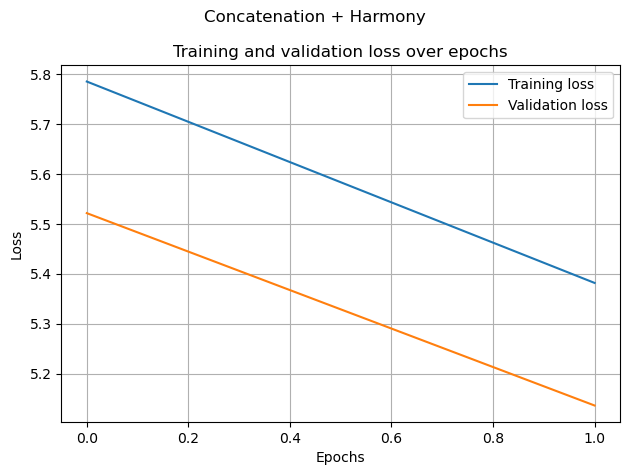

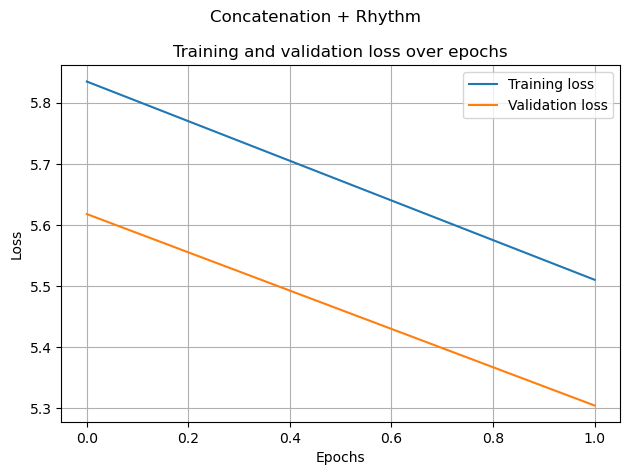

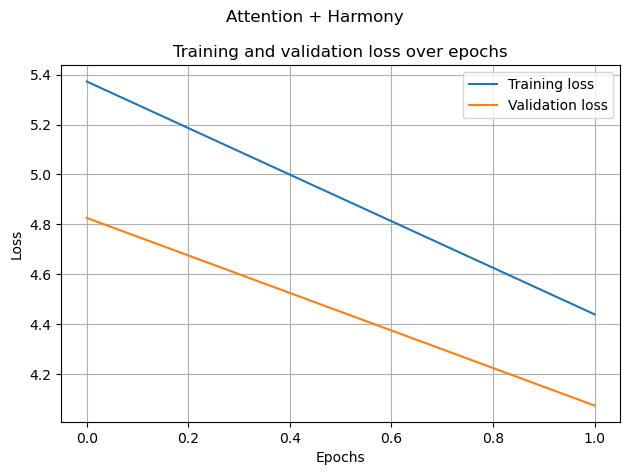

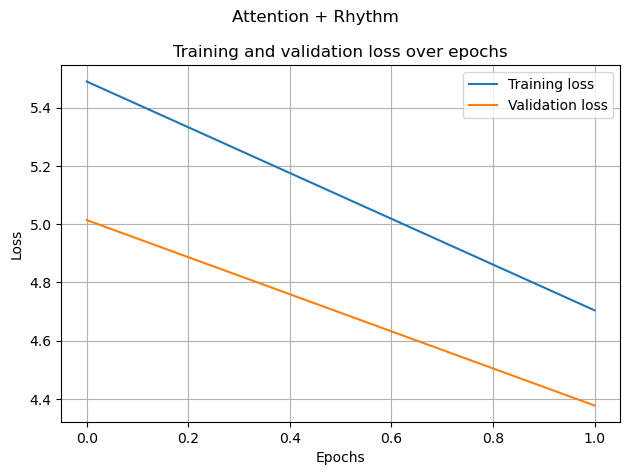

In [691]:
display_graphs_for_loss(harmony_concatenation_training_loss, harmony_concatenation_validation_loss, subtitle="Concatenation + Harmony")
display_graphs_for_loss(rhythm_concatenation_training_loss, rhythm_concatenation_validation_loss, subtitle="Concatenation + Rhythm")
display_graphs_for_loss(attention_training_loss_harmony, attention_validation_loss_harmony, subtitle="Attention + Harmony")
display_graphs_for_loss(attention_rhythm_training_loss, attention_rhythm_validation_loss, subtitle="Attention + Rhythm")

Comparing models against each other

In [692]:
general_training_loss = [("Concatenation + Harmony", harmony_concatenation_training_loss),
 ("Concatenation + Rhythm", rhythm_concatenation_training_loss),
 ("Attention + Harmony", attention_training_loss_harmony),
 ("Attention + Rhythm", attention_rhythm_training_loss)]

general_validation_loss = [("Concatenation + Harmony", harmony_concatenation_validation_loss),
 ("Concatenation + Rhythm", rhythm_concatenation_validation_loss),
 ("Attention + Harmony", attention_validation_loss_harmony),
 ("Attention + Rhythm", attention_rhythm_validation_loss)]

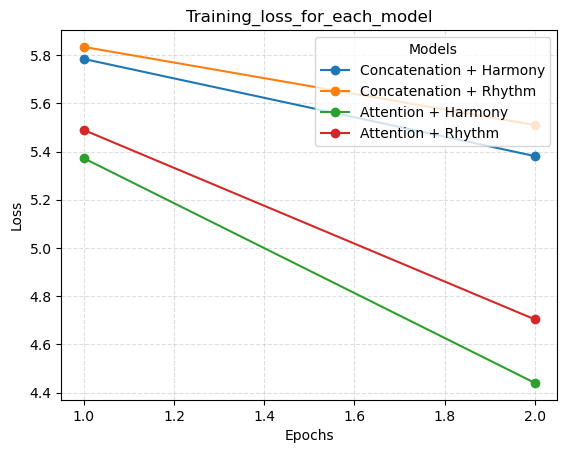

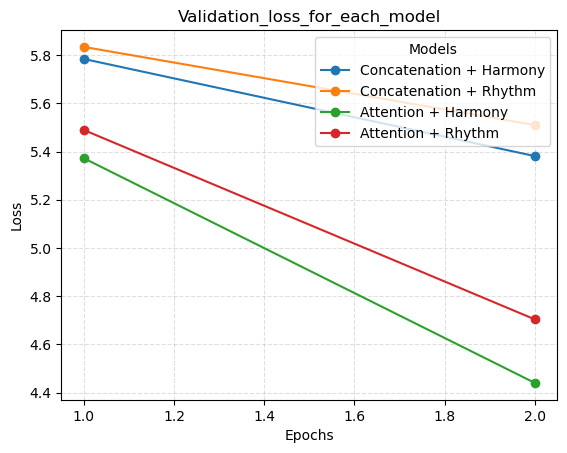

In [693]:
display_graph_comparing_each_model("Training_loss_for_each_model", general_training_loss)
display_graph_comparing_each_model("Validation_loss_for_each_model", general_training_loss)

<font size=6>Generating Lyrics</font>

A function that returns the k most likely words given the input, used for coherent lyric generatin.

In [694]:
@torch.no_grad()
def predict_next_word(
    model: nn.Module,
    word_sequence: list[str],
    artist_index: int,
    melody_vec,
    word_to_id: dict[str, int],
    id_to_word: dict[int, str],
    embedding_weight: torch.Tensor,
    device: str = "cpu",
    forbidden_words: list[str] | None = None,
    strengthened_words: list[tuple[str, float]] | None = None,
):
    model = model.to(device).eval()

    # embedding matrix on device
    if embedding_weight.device.type != device:
        embedding_weight = embedding_weight.to(device)

    # melody -> [M]
    melody_vec = torch.as_tensor(melody_vec, dtype=torch.float32, device=device)

    # seq -> ids -> embeddings
    unk_id = word_to_id.get(UNK_STRING, UNK_ID)
    seq_ids = torch.tensor([word_to_id.get(w, unk_id) for w in word_sequence],
                           device=device, dtype=torch.long)              # [T]
    seq_embs = embedding_weight[seq_ids]                                  # [T, E]

    T = seq_embs.size(0)
    # broadcast melody + artist
    melody_broadcast = melody_vec.expand(T, -1)                           # [T, M]
    # NOTE: your model’s artist dim must equal size_of_artist_index_dim; here we use 1
    artist_broadcast = torch.full((T, 1), float(artist_index),
                                  dtype=torch.float32, device=device)     # [T, 1]

    # concat → [1, T, E+M+artist_dim]
    x = torch.cat([seq_embs, melody_broadcast, artist_broadcast], dim=1).unsqueeze(0)  # [1,T,D]

    # forward
    out = model(x)
    if isinstance(model, LyricsGenerator_Attention):
        logits = out[0]         # attention model: [1, V]
    elif isinstance(model, LyricsGenerator_Concatenation):
        logits = out[:, -1, :]  # [1, V]
    else:
        raise ValueError(f"Model: {model} is not recognized.")
    
    logits = logits.squeeze(0)  # [V]
    # forbid
    if forbidden_words:
        forb_idx = [word_to_id[w] for w in forbidden_words if w in word_to_id]
        if forb_idx:
            logits[torch.tensor(forb_idx, device=device, dtype=torch.long)] = float("-inf")

    probs = torch.softmax(logits, dim=-1)  # [V]

    # strengthen: set explicit probabilities for selected words
    if strengthened_words:
        pairs = [(w, float(p)) for (w, p) in strengthened_words if (w in word_to_id) and (p >= 0.0)]
        if pairs:
            idxs = torch.tensor([word_to_id[w] for (w, _) in pairs], device=device, dtype=torch.long)
            p_desired = torch.tensor([min(p, 1.0) for (_, p) in pairs], device=device, dtype=probs.dtype)
            # aggregate dupes
            uniq, inv = torch.unique(idxs, return_inverse=True)
            p_agg = torch.zeros_like(uniq, dtype=probs.dtype).scatter_add(0, inv, p_desired)

            base = probs.clone()
            base[uniq] = 0.0
            base_sum = base.sum()
            sum_p = p_agg.sum()

            if float(sum_p) >= 1.0 - 1e-8 or base_sum <= 1e-12:
                probs = torch.zeros_like(probs)
                probs[uniq] = p_agg / (sum_p + 1e-12)
            else:
                remain = 1.0 - float(sum_p)
                base = base * (remain / (base_sum + 1e-12))
                probs = base
                probs[uniq] = p_agg

    idx = torch.multinomial(probs, num_samples=1, replacement=True)
    return id_to_word[int(idx.item())]

Printing the generated text and handling tokens

In [695]:
def print_generated_lyrics(generated_lyrics: list[str]):
    capitalize = True
    for word in generated_lyrics:
        if word == EOL_STRING:
            capitalize = True
            print()
        if word == EOS_STRING:
            break
        if word != EOL_STRING:
            if capitalize:
                capitalize = False
                print(word.title(), end=' ')
            else:
                print(word, end=' ')
    print()

Generating the lyrics and maintaining the lyrics generated

In [705]:
def generate_lyrics(
        model_to_use: nn.Module,
        model_title: str,
        initial_word: str,
        melody_features: np.ndarray,
        melody_title: str,
        artist_to_use: str,
        word_to_id: dict[str, int],
        id_to_word: dict[int, str],
        artist_to_index: dict[str, int],
        word_embeddings: dict[str, np.ndarray],
        max_song_length: int = MAX_SONG_LENGTH_WORDS,
        sequence_length: int = SEQUENCE_LENGTH,
        device: str = "cuda" if torch.cuda.is_available() else "cpu"
):
    """
    Generates lyrics word by word using the model, melody, and artist.
    Picks next word randomly from top_k candidates according to their normalized probabilities.
    Artificially increases probability of EOS_STRING after half of max_song_length.
    Prints the generated lyrics with line breaks at <eol>.
    Enforces some more grammatical rules.
    Returns: generated_lyrics (list of str), artist, melody_title.
    """
    print(f"------------------------- Model: {model_title} -------------------------")
    print(f"Generating song")
    print(f"--------------------------------------------------")
    print(f"Initial Word: {initial_word}")
    print(f"Artist: {artist_to_use}")
    print(f"Melody: {melody_title}")
    print(f"--------------------------------------------------")
    initial_word = initial_word.lower()
    melody_vec = torch.as_tensor(melody_features[0], dtype=torch.float32, device=device)
    artist_idx = artist_to_index.get(artist_to_use.lower(), -1)
    if artist_idx == -1:
        print(f"Warning: Artist '{artist_to_use}' not found, using index -1.")

    embedding_weight = torch.from_numpy(
        np.stack([word_embeddings[w].astype(np.float32) for w in word_to_id], axis=0)
    ).to(device)
    context: deque = deque()
    context.extendleft([UNK_STRING for _ in range(sequence_length - 1)])
    context.appendleft(initial_word)
    unk_index: int = 1
    generated_lyrics = [initial_word]
    words_in_song: int = 0
    current_word: str = initial_word
    minimum_song_length = int(max_song_length / 2)
    current_words_in_line: int = 1
    current_word = ""
    next_word = ""
    words_not_to_end_lines_on: list[str] = ['the']
    number_of_lines_in_song: int = 0
    while True:
        # Tries to enforce certain rules.
        # Don't allow end of song before minimum amount of lines.
        # Don't repeat the same word twice
        # Don't allow lines that are too short.
        # Don't end lines on words in a way that would make no sense.
        forbidden_words = [current_word]
        strengthened_words = list()
        if words_in_song < int(minimum_song_length):
            forbidden_words.append(EOS_STRING)
        if current_word in words_not_to_end_lines_on:
            forbidden_words.extend([EOL_STRING, EOS_STRING])
        if current_words_in_line < MIN_LINE_LENGTH:
            forbidden_words.append(EOL_STRING)
        if current_words_in_line > int(MAX_LINE_LENGTH / 2):
            probability_of_eol: float = min((current_words_in_line - int(MAX_LINE_LENGTH / 2))/ int(MAX_LINE_LENGTH/2), 1.0)
            strengthened_words.append((EOL_STRING, probability_of_eol))
        if words_in_song > int(MAX_SONG_LENGTH_WORDS / 2):
            probability_of_eos: float = min((words_in_song - int(MAX_SONG_LENGTH_WORDS / 2))/ int(MAX_SONG_LENGTH_WORDS/2), 1.0)
            strengthened_words.append((EOS_STRING, probability_of_eos))
        next_word = predict_next_word(
            model=model_to_use,
            word_sequence=context,
            artist_index=artist_idx,
            melody_vec=melody_vec,
            word_to_id=word_to_id,
            id_to_word=id_to_word,
            embedding_weight=embedding_weight,
            forbidden_words=forbidden_words,
            strengthened_words=strengthened_words,
            device=device,
        )
        if next_word == EOS_STRING and current_word == EOL_STRING:
            generated_lyrics[-1] = next_word # In case an end of song comes after linebreak, just end the song instead.
        else:
            generated_lyrics.append(next_word)
        current_word = next_word
        if unk_index < sequence_length:
            context[unk_index] = next_word
            unk_index += 1
        else:
            context.popleft()
            context.append(next_word)
        if next_word == EOS_STRING:
            break
        if words_in_song >= max_song_length:
            generated_lyrics.append(EOS_STRING)
            break
        if next_word != EOL_STRING:
            words_in_song += 1
            current_words_in_line += 1
        else:
            number_of_lines_in_song += 1
            current_words_in_line = 0
    print_generated_lyrics(generated_lyrics=generated_lyrics)
    print(f"--------------------------------------------------")
    print("\n--- End of generated lyrics ---")
    print(f"--------------------------------------------------")
    print(f'Number of words in lyrics: {words_in_song}')
    print(f'Number of lines in lyrics: {number_of_lines_in_song}')
    print(f"--------------------------------------------------")
    return generated_lyrics, artist_to_use, melody_title

<font size=6>Testing with the testing set</font>

For each melody and each model, the output of the architecture given the melody and the initial word of the real lyrics.

In [706]:
harmony_model_name_model_list: list[tuple[str, nn.Module]] = [
    ("Concatenation + Harmony", model_concatenation_harmony),
    ("Attention + Harmony", attention_model_harmony)
]
rhythm_model_name_model_list: list[tuple[str, nn.Module]] = [
    ("Concatenation + Rhythm", model_concatenation_rhythm),
    ("Attention + Rhythm", attention_model_rhythm)
]

In [707]:
for model_name, model in harmony_model_name_model_list:
    print('======================================')
    print('===========Harmoney Models============')
    print('======================================')
    for test_song in test_midi_data:
        test_song: SongData
        lyrics, artist, melody = generate_lyrics(
            model_to_use=model,
            model_title=model_name,
            initial_word=test_song.lyrics[0],
            melody_features=test_song.midi_harmony_and_pitch_features,
            melody_title=test_song.title,
            artist_to_use=test_song.artist,
            word_to_id=word_to_id,
            id_to_word=id_to_word,
            artist_to_index=artist_to_index,
            word_embeddings=unified_embeddings,
            max_song_length=len([word for word in test_song.lyrics if word != EOL_STRING])
        )
    print('======================================')


===========Harmoney Models============
------------------------- Model: Concatenation + Harmony -------------------------
Generating song
--------------------------------------------------
Initial Word: close
Artist: the bangles
Melody: eternal flame
--------------------------------------------------
Close light border intentions melting 
Minute nice the him your dread hoping stand fa the 
Would your enough adore are i from myself 
Of world the a of 
We dont hear upside one real fed you 
Me by bout the anime yourself 
--------------------------------------------------

--- End of generated lyrics ---
--------------------------------------------------
Number of words in lyrics: 41
Number of lines in lyrics: 5
--------------------------------------------------
------------------------- Model: Concatenation + Harmony -------------------------
Generating song
--------------------------------------------------
Initial Word: if
Artist: billy joel
Melody: honesty
-----------------------------

In [717]:
for model_name, model in rhythm_model_name_model_list:
    print('==================================================================================')
    print('==================================Rhythm Models===================================')
    print('==================================================================================')
    for test_song in test_midi_data:
        test_song: SongData
        lyrics, artist, melody = generate_lyrics(
            model_to_use=model,
            model_title=model_name,
            initial_word=test_song.lyrics[0],
            melody_features=test_song.midi_rhythm_and_dynamic_features,
            melody_title=test_song.title,
            artist_to_use=test_song.artist,
            word_to_id=word_to_id,
            id_to_word=id_to_word,
            artist_to_index=artist_to_index,
            word_embeddings=unified_embeddings,
            max_song_length=len([word for word in test_song.lyrics if word != EOL_STRING])
        )

==================================Rhythm Models===================================
------------------------- Model: Concatenation + Rhythm -------------------------
Generating song
--------------------------------------------------
Initial Word: close
Artist: the bangles
Melody: eternal flame
--------------------------------------------------
Close like the i off 
Glass can you up go a 
I cant to photograph my love color will 
Way didnt dance and a 
Measure a of catch photographs 
Try you the heart long 
Ronnie way do ill you oo tonight maybe 
Come to merry alone like 
--------------------------------------------------

--- End of generated lyrics ---
--------------------------------------------------
Number of words in lyrics: 46
Number of lines in lyrics: 7
--------------------------------------------------
------------------------- Model: Concatenation + Rhythm -------------------------
Generating song
--------------------------------------------------
Initial Word: if
Artist: billy

For each melody, the output of the architecture given the melody and different starting words. The same word should be used for all melodies.

In [718]:
starting_words: list[str] = ['love', 'baby', 'time']
for model_name, model in harmony_model_name_model_list:
    print('======================================')
    print('===========Harmoney Models============')
    print('======================================')
    for word in starting_words:
        print(f'-------------Initial Word Selected: {word}-------------------')
        for test_song in test_midi_data:
            print('--------------------------------')
            test_song: SongData
            lyrics, artist, melody = generate_lyrics(
                model_to_use=model,
                model_title=model_name,
                initial_word=word,
                melody_features=test_song.midi_harmony_and_pitch_features,
                melody_title=test_song.title,
                artist_to_use=test_song.artist,
                word_to_id=word_to_id,
                id_to_word=id_to_word,
                artist_to_index=artist_to_index,
                word_embeddings=unified_embeddings,
                max_song_length=len([word for word in test_song.lyrics if word != EOL_STRING])
            )
            print('--------------------------------')
    print('======================================')

===========Harmoney Models============
-------------Initial Word Selected: love-------------------
--------------------------------
------------------------- Model: Concatenation + Harmony -------------------------
Generating song
--------------------------------------------------
Initial Word: love
Artist: the bangles
Melody: eternal flame
--------------------------------------------------
Love i when is good la 
Red oh names terminally you him rubs santa 
Me like to flow sail the lane 
A cares guaranteed the who do knew 
Daddy we to good and one 
Be when the and to 
Then system make down ooh 
Conductor got with 
--------------------------------------------------

--- End of generated lyrics ---
--------------------------------------------------
Number of words in lyrics: 46
Number of lines in lyrics: 7
--------------------------------------------------
--------------------------------
--------------------------------
------------------------- Model: Concatenation + Harmony ----------

In [719]:
starting_words: list[str] = ['love', 'baby', 'time']
for model_name, model in rhythm_model_name_model_list:
    print('======================================')
    print('============Rhythm Models=============')
    print('======================================')
    for word in starting_words:
        print(f'-------------Initial Word Selected: {word}-------------------')
        for test_song in test_midi_data:
            print('--------------------------------')
            test_song: SongData
            lyrics, artist, melody = generate_lyrics(
                model_to_use=model,
                model_title=model_name,
                initial_word=word,
                melody_features=test_song.midi_rhythm_and_dynamic_features,
                melody_title=test_song.title,
                artist_to_use=test_song.artist,
                word_to_id=word_to_id,
                id_to_word=id_to_word,
                artist_to_index=artist_to_index,
                word_embeddings=unified_embeddings,
                max_song_length=len([word for word in test_song.lyrics if word != EOL_STRING])
            )
            print('--------------------------------')
    print('======================================')

============Rhythm Models=============
-------------Initial Word Selected: love-------------------
--------------------------------
------------------------- Model: Concatenation + Rhythm -------------------------
Generating song
--------------------------------------------------
Initial Word: love
Artist: the bangles
Melody: eternal flame
--------------------------------------------------
Love in you and party 
Mind in of ship night but 
Not each story by until the where everythings me 
And the paint this you the and 
It turned money tears you 
Its flowers stack mirage and 
As makes my a of 
Long a it king night 
Matter all much were zone 
Tall 
--------------------------------------------------

--- End of generated lyrics ---
--------------------------------------------------
Number of words in lyrics: 52
Number of lines in lyrics: 9
--------------------------------------------------
--------------------------------
--------------------------------
------------------------- Model: C